# Theoretical Neuroscience: Project 1

**Professor:** Brian Frost

**Spring 2025**

---

This notebook implements spike‐train generation using concepts from Chapter 1 of _Dayan and Abbott’s Theoretical Neuroscience_.

We consider:

- **Homogeneous Poisson Process:** Spike trains with a constant firing rate

- **Inhomogeneous Poisson Process:** Spike trains with a time‐varying firing rate

- **Refractory Period:** After a spike the neuron is “blocked” for an interval drawn from a hard‐coded (exponential) distribution

Computations for each process (with and without refractoriness):

- The **Fano factor** (variance/mean of spike counts over many trials)

- The **interspike interval (ISI) probability distributions**

- The **coefficient of variation (CV)** of the ISIs

- The **spike‐train autocorrelation function**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union, Dict, Any

### Helper Functions

In [2]:
def spike_train2spike_times(spike_train: np.ndarray, dt: float):
    return np.where(spike_train)[0] * dt # np.where returns a tuple where the first element is an array of the indices of the True values in the input array
spike_train2spike_times(np.array([0, 1, 0, 1, 0]), dt=0.001)

array([0.001, 0.003])

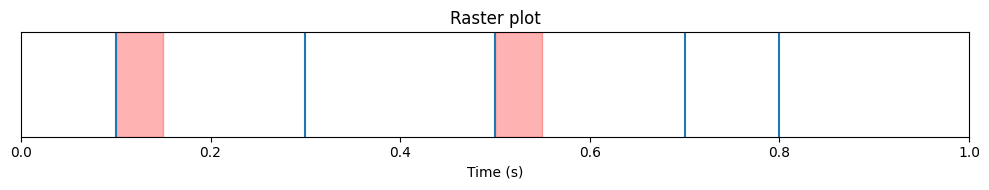

In [3]:
def raster_plot(ax, spike_times, highlight_ref: bool=True, refractory_periods: list=[], xlim=(0, 1), title="Raster plot"):
    # Plot vertical lines for each spike.
    ax.vlines(spike_times, 0, 1)
    
    # Overlay the refractory periods if highlight_ref is True.
    if highlight_ref and any(refractory_periods):
        for start, end in refractory_periods:
            ax.axvspan(start, end, color='red', alpha=0.3)
        
    ax.set_ylim(0, 1)
    ax.set_xlim(xlim)
    ax.set_xlabel("Time (s)")
    ax.get_yaxis().set_visible(False)
    ax.set_title(title)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
raster_plot(ax, [0.1, 0.3, 0.5, 0.7, 0.8], refractory_periods=[(0.1, 0.15), (0.5, 0.55)], title="Raster plot")
plt.tight_layout()
plt.show()


## Spike Train Generation

**Poisson Process**

The poisson distribution is given by

$$
P_T[n] = \frac{(rT)^n}{n!} \exp(-rT).
$$

where $P_T[n]$ is the probability of observing $n$ spikes in time $T$ given a firing rate of $r$. For a homogeneous poisson process, the firing rate is constant; for an inhomogeneous poisson process, the firing rate is time-varying.

**Refractory Period**

> "For a few milliseconds just after an action potential has been fired, it may be virtually impossible to initiate another spike. This is called the absolute refractory period." ({cite}`dayan_theoretical_2001`, p.21)

> "Refractory effects can be incorporated into a Poisson model of spike generation by setting the firing rate to 0 immediately after a spike is fired, and then letting it return to its predicted value according to some dynamic rule such as an exponential recovery." ({cite}`dayan_theoretical_2001`, p.48)

> "Both the length of the absolute and relative refractory period depend on the nerve cell under consideration, but typical values in the central nervous system are 0.5–1 ms and ≈ 10 ms, respectively." {cite}`gabbiani_mathematics_2010`

The rule I implemented is an absolute refractory period of 1 ms summed with a relative refractory period drawn from an exponential distribution with a mean of 10 ms.
The exponential distribution is given by

$$
f(x; \frac{1}{\beta}) = \frac{1}{\beta} \exp(-\frac{x}{\beta}),
$$

where $\beta$ is the mean of the distribution.


In [4]:
# Initialize random number generator
rng = np.random.default_rng()

### Trial Parameters and Time Varying Firing Rate

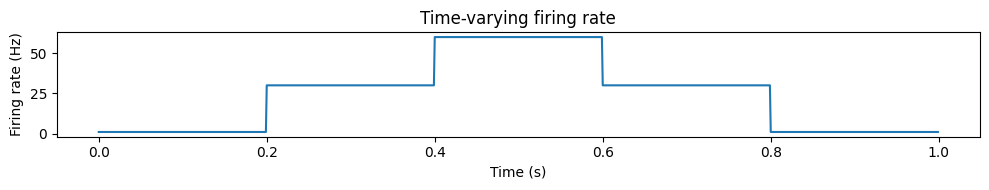

In [5]:
# Define parameters
T = 1 
dt = 0.001
abs_ref = 0.001
rel_ref_mean = 0.01
r = 60

# Time varying firing rate
r_t = np.repeat([1, 30, 60, 30, 1], round((T/dt)/5))
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(np.arange(0, T, dt), r_t)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Firing rate (Hz)")
ax.set_title("Time-varying firing rate")
plt.tight_layout()
plt.show()

### Simple Spike Generator

For the spike generation I initially used the following procedure:

> "Spike sequences can be simulated by using some estimate of the firing rate, $r_{\text{est}}(t)$, predicted from knowledge of the stimulus, to drive a Poisson process. A simple procedure for generating spikes in a computer program is based on the fact that the estimated probability of firing a spike during a short interval of duration $\Delta t$ is $r_{\text{est}}(t) \Delta t$. The program progresses through time in small steps of size $\Delta t$ and generates, at each time step, a random number $x*{\text{rand}}$ chosen uniformly in the range between 0 and 1. If $r_{\text{est}}(t) \Delta t > x\_{\text{rand}}$ at that time step, a spike is fired; otherwise it is not." ({cite}`dayan_theoretical_2001`, p.47)

In [6]:
def simple_spike_generator(
    r: Union[float, np.ndarray],
    T: float = 1,
    dt: float = 0.001,
    refractory: bool = False,
    abs_ref: float = 0.001,
    rel_ref_mean: float = 0.01,
) -> np.ndarray:
    """Generate a spike train array according to a Poisson process.

    Args:
        r (Union[float, np.ndarray]): Constant firing rate if scalar or time varying array of firing rates at each time step (Hz).
        T (float, optional): Trial duration (s). Defaults to 1.
        dt (float, optional): Time step size (s). Defaults to 0.001.
        refractory (bool, optional): Whether to include refractory periods. Defaults to False.
        abs_ref (float, optional): Absolute refractory period (s). Defaults to 0.001.
        rel_ref_mean (float, optional): Mean relative refractory period (s). Defaults to 0.01.

    Returns:
        np.ndarray: spike train array; when a spike is present, the value is 1, otherwise 0.
    """
    spike_train_length = round(T / dt)
    spike_train = np.zeros(spike_train_length)
    next_possible_index = 0  # index until which the neuron is refractory

    # Use a homogeneous poisson process if r is scalar, inhomogeneous otherwise (r should be an array of the same length as spike_train)
    homogeneous = np.isscalar(r)         
    
    for i in range(spike_train_length):
        if i < next_possible_index:
            continue

        firing_rate = r if homogeneous else r[i]
        if rng.random() < firing_rate * dt:
            spike_train[i] = 1
            if refractory:
                ref_period = abs_ref + rng.exponential(scale=rel_ref_mean)
                ref_time_steps = np.ceil(ref_period / dt)
                next_possible_index = i + ref_time_steps

    return spike_train
simple_spike_generator(60)[:10]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

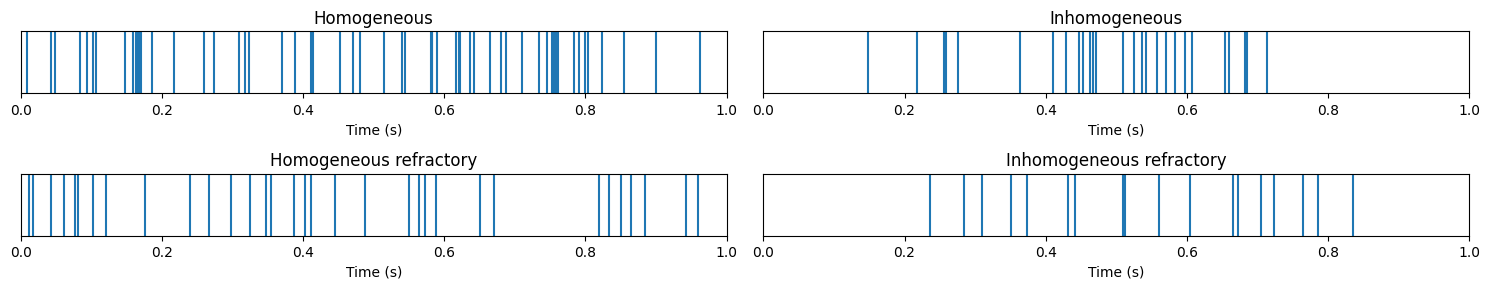

In [7]:
# Generate spike trains
simple_spike_train_homogeneous = simple_spike_generator(r, T=T, dt=dt, abs_ref=abs_ref, refractory=False, rel_ref_mean=rel_ref_mean)
simple_spike_train_inhomogeneous = simple_spike_generator(r_t, T=T, dt=dt, abs_ref=abs_ref, refractory=False, rel_ref_mean=rel_ref_mean)
simple_spike_train_homogeneous_refractory = simple_spike_generator(r, T=T, dt=dt, abs_ref=abs_ref, refractory=True, rel_ref_mean=rel_ref_mean)
simple_spike_train_inhomogeneous_refractory = simple_spike_generator(r_t, T=T, dt=dt, abs_ref=abs_ref, refractory=True, rel_ref_mean=rel_ref_mean)

# Plot spike trains
fig, axes = plt.subplots(2, 2, figsize=(15, 3))
raster_plot(axes[0, 0], spike_train2spike_times(simple_spike_train_homogeneous, dt=dt), title="Homogeneous")
raster_plot(axes[0, 1], spike_train2spike_times(simple_spike_train_inhomogeneous, dt=dt), title="Inhomogeneous")
raster_plot(axes[1, 0], spike_train2spike_times(simple_spike_train_homogeneous_refractory, dt=dt), title="Homogeneous refractory")
raster_plot(axes[1, 1], spike_train2spike_times(simple_spike_train_inhomogeneous_refractory, dt=dt), title="Inhomogeneous refractory")
fig.tight_layout()

### Interspike Interval Spike Generators

**Faster homogeneous spike generator**
> For a constant firing rate, it is faster to compute spike times $t_i$ for $i = 1, 2, ... n$ iteratively by generating interspike intervals from an exponential probability density ({cite}`dayan_theoretical_2001`, p.47)

**Faster inhomogeneous spike generator**
> Rejection sampling or spike thinning. The thinning technique requires a bound $r_{\text{max}}$ on the estimated firing rate such that $r_{\text{est}}(t) \leq r_{\text{max}}$ at all times. We first generate a spike sequence corresponding to the constant rate $r_{\text{max}}$ by iterating the rule $t_{i+1} = t_i - \ln(x_{\text{rand}}) / r_{\text{max}}$. The spikes are then thinned by generating another $x_{\text{rand}}$ for each $i$ and removing the spike at time $t_i$ from the train if $r_{\text{est}}(t_i) / r_{\text{max}} < x_{\text{rand}}$. If $r_{\text{est}}(t_i) / r_{\text{max}} \geq x_{\text{rand}}$, spike $i$ is retained. Thinning corrects for the difference between the estimated time-dependent rate and the maximum rate. ({cite}`dayan_theoretical_2001`, p.47)

**Refractory Period**

The refractory period is implemented using a similar spike thinning process, where spikes are removed if they occur within the refractory period of the previous spike.

**Comparison of Spike Generators**

| Attribute | Simple Generator | Fast Generator |
| --- | --- | --- |
| Precision | Limited by bin size | Up to 17 decimal points {cite}`python_floating-point_2025`|
| Length of Spike Train | Fixed | Arbitrary (Can be cutoff to fixed length) |
| Number of Spikes | Arbitrary | Fixed (Becomes arbitrary after cutoff) |


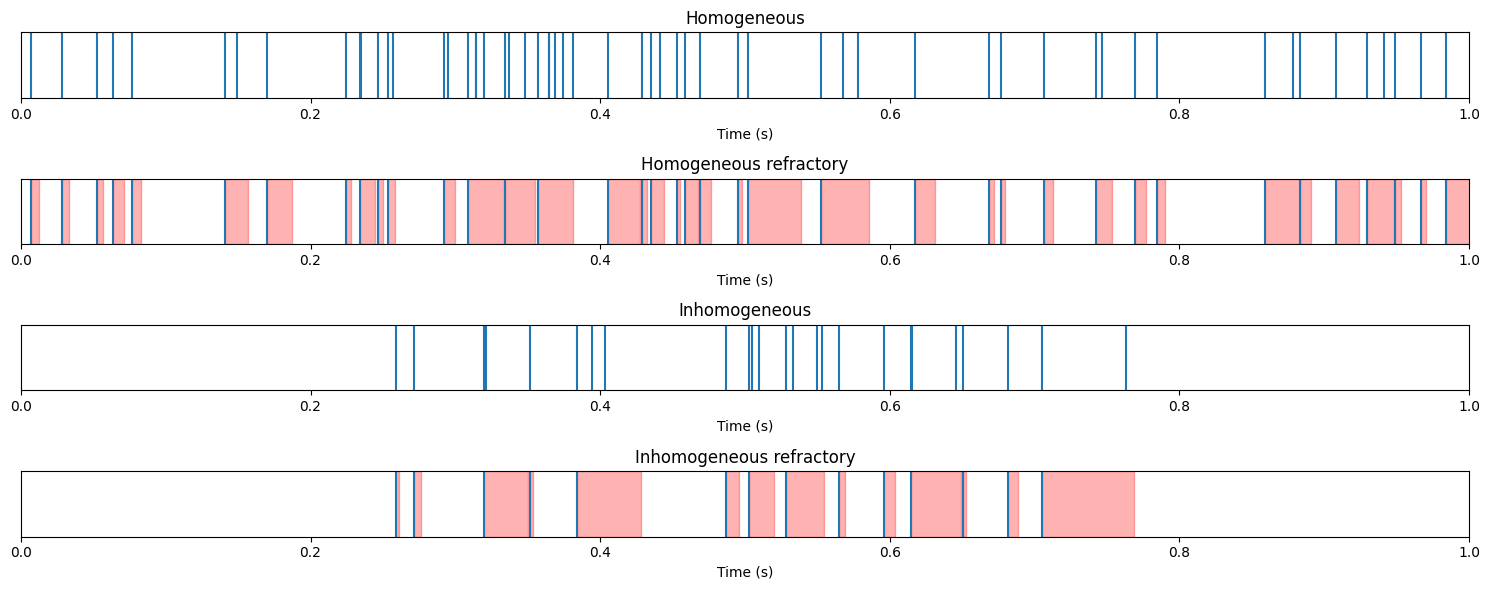

In [8]:
def fast_spike_generator(
    r: Union[float, np.ndarray],
    T: float = 1,
    dt: float = 0.001,
    abs_ref: float = 0.001,
    rel_ref_mean: float = 0.01,
) -> Dict[str, Dict[str, Any]]:
    """Generate a dictionary of spike trains driven by a Poisson process.

    Args:
        r (Union[float, np.ndarray]): Constant firing rate if scalar or time varying array of firing rates at each time step (Hz).
        T (float, optional): Trial duration (s). Defaults to 1.
        dt (float, optional): Time step size of `r_t` (s). Defaults to 0.001.
        abs_ref (float, optional): Absolute refractory period (s). Defaults to 0.001.
        rel_ref_mean (float, optional): Mean relative refractory period (s). Defaults to 0.01.

    Returns:
        (Dict[str, Any]): {"Spike Times Poisson": np.ndarray, "Spike Times Refractory": np.ndarray, "Refractory Periods": list}
    """
    # Use a homogeneous poisson process if r is scalar, inhomogeneous otherwise (r should be an array of the same length as spike_train)
    homogeneous = np.isscalar(r)         

    if homogeneous:
        interspike_intervals = rng.exponential(scale=1/r, size=round(r * T * 2)) # Scale by 2 to ensure we have enough spikes
    else:
        max_firing_rate = max(r)
        interspike_intervals = rng.exponential(scale=1/max_firing_rate, size=round(max_firing_rate * T * 2))
    spike_times = np.cumsum(interspike_intervals)
    spike_times = spike_times[spike_times < T] # Cutoff at extra spikes at T
    
    # Spike thinning for inhomogeneous Poisson process
    if not homogeneous:
        spike_indices_to_remove = []
        for i, spike_time in enumerate(spike_times):
            firing_rate_index = round(spike_time / dt) - 1 # index of the spike time in the time varying firing rate array, -1 to account for 0 indexing
            if r_t[firing_rate_index] / max_firing_rate < rng.random():
                spike_indices_to_remove.append(i)
        spike_times = np.delete(spike_times, spike_indices_to_remove)
    
    valid_spike_times = []
    refractory_periods = []
    i = 0
    while i < len(spike_times):
        current_time = spike_times[i]
        valid_spike_times.append(current_time)

        # The refractory period for this spike.
        ref_period = abs_ref + rng.exponential(scale=rel_ref_mean)
        refractory_periods.append((current_time, current_time + ref_period))

        # Skip any spikes within this refractory period
        i += 1
        while i < len(spike_times) and spike_times[i] < current_time + ref_period:
            i += 1

    refractory_periods = refractory_periods.copy()
    spike_times_refractory = np.array(valid_spike_times)
    return {"Spike Times Poisson": spike_times,
            "Spike Times Refractory": spike_times_refractory,
            "Refractory Periods": refractory_periods}
spikes_dict_homogeneous = fast_spike_generator(r, T=T, dt=dt, abs_ref=abs_ref, rel_ref_mean=rel_ref_mean)
spikes_dict_inhomogeneous = fast_spike_generator(r_t, T=T, dt=dt, abs_ref=abs_ref, rel_ref_mean=rel_ref_mean)

# Plot spike trains
fig, axes = plt.subplots(4, 1, figsize=(15, 6))
raster_plot(axes[0], spikes_dict_homogeneous["Spike Times Poisson"], title="Homogeneous")
raster_plot(axes[1], spikes_dict_homogeneous["Spike Times Refractory"], refractory_periods=spikes_dict_homogeneous["Refractory Periods"], title="Homogeneous refractory")
raster_plot(axes[2], spikes_dict_inhomogeneous["Spike Times Poisson"], title="Inhomogeneous")
raster_plot(axes[3], spikes_dict_inhomogeneous["Spike Times Refractory"], refractory_periods=spikes_dict_inhomogeneous["Refractory Periods"], title="Inhomogeneous refractory")
fig.tight_layout()

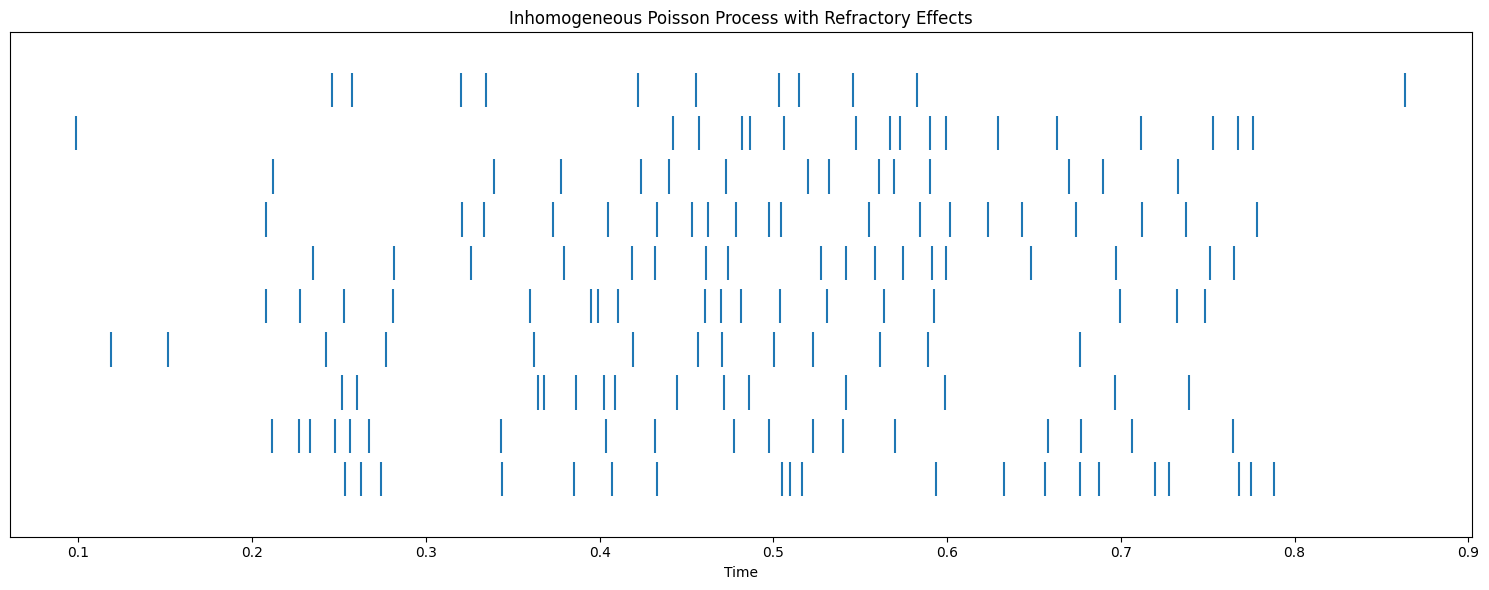

In [9]:
# Multiple Trials of Spike Generation
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

trials = []
for i in range(10):
    trials.append(fast_spike_generator(r_t, T=T, dt=dt, abs_ref=abs_ref, rel_ref_mean=rel_ref_mean)["Spike Times Refractory"])
ax.set_title("Inhomogeneous Poisson Process with Refractory Effects")
ax.set_xlabel("Time")
ax.get_yaxis().set_visible(False)
ax.eventplot(trials, linelengths=0.8)
fig.tight_layout()

## Computations

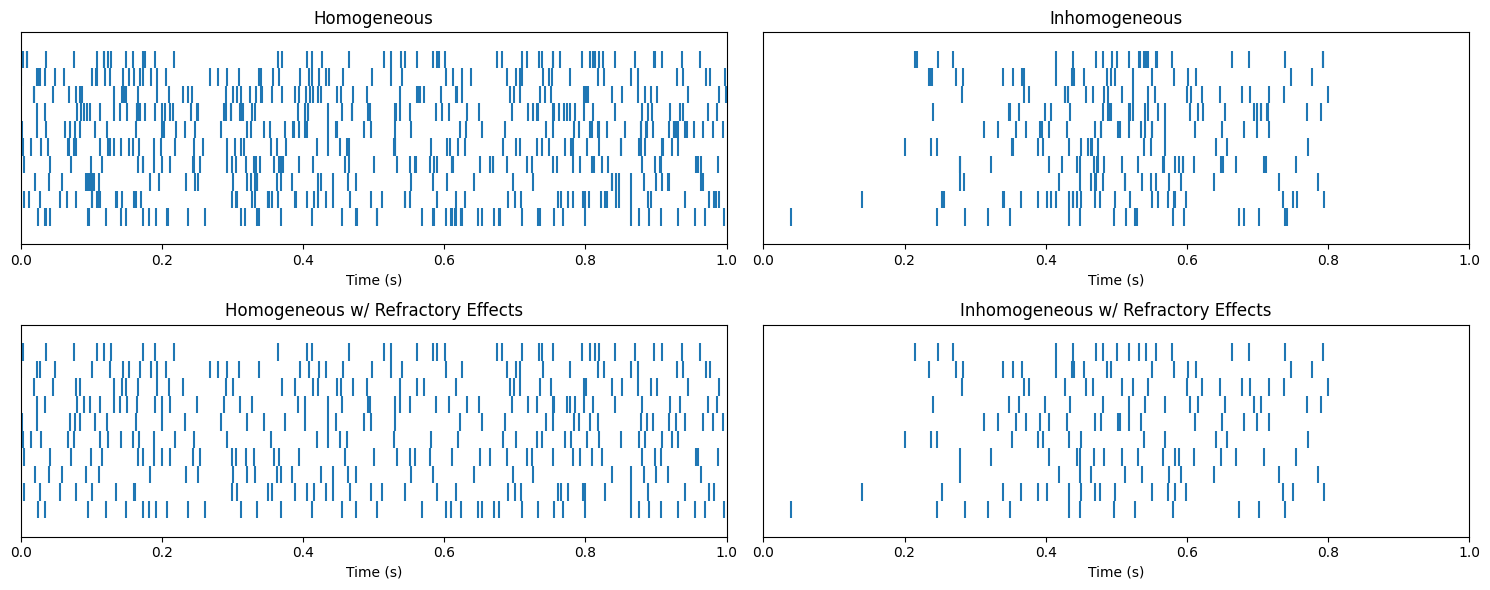

In [10]:
num_trials = 1000
poisson_processes = ["Homogeneous", "Inhomogeneous"]
all_trials = {}
for process in poisson_processes:
    all_trials[process] = []
    all_trials[f"{process} w/ Refractory Effects"] = []
    for i in range(num_trials):
        spikes_dict = fast_spike_generator(
            r if process == "Homogeneous" else r_t, T=T, dt=dt, abs_ref=abs_ref, rel_ref_mean=rel_ref_mean
        )
        all_trials[process].append(spikes_dict["Spike Times Poisson"])
        all_trials[f"{process} w/ Refractory Effects"].append(spikes_dict["Spike Times Refractory"])
        
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, (key, trials) in zip(axes.flatten('F'), all_trials.items()):
    ax.eventplot(trials[:10])
    ax.set_title(key)
    ax.set_xlabel("Time (s)")
    ax.get_yaxis().set_visible(False)
    ax.set_xlim(0, 1)

fig.tight_layout()

### Fano Factor

> The ratio of these two quantities, $\sigma_n^2 / \langle n \rangle$, is called the Fano factor and takes the value 1 for a homogeneous Poisson process, independent of the time interval $T$. ({cite}`dayan_theoretical_2001`, p.44)

In [11]:
statistics = []
for key, trials in all_trials.items():
    num_spikes = [len(trial) for trial in trials]
    num_spikes_variance = np.var(num_spikes)
    num_spikes_trial_avg = np.mean(num_spikes)
    fano_factor = num_spikes_variance / num_spikes_trial_avg if num_spikes_trial_avg != 0 else np.nan

    statistics.append([key, num_spikes_variance, num_spikes_trial_avg, fano_factor])
pd.DataFrame(statistics, columns=["Process", "Spikes Variance", "Spikes Trial Avg", "Fano Factor"])

,Process,Spikes Variance,Spikes Trial Avg,Fano Factor
0,Homogeneous,61.876256,59.912,1.032786
1,Homogeneous w/ Refractory Effects,19.209375,36.075,0.532484
2,Inhomogeneous,23.549399,24.449,0.963205
3,Inhomogeneous w/ Refractory Effects,9.323559,16.729,0.557329


The Fano factors of the purely poisson processes are expectedly 1, while the processes including refractory effects are closer to 1/2. Since the Fano Factor is the ratio of the variance to the mean of the number of spikes, a Fano factor of 1/2 indicates that the variance is lower than expected or the mean is higher than expected. Since refactory effects should only reduce the mean number of spikes, the former is more likely. I suspect that the refractory period is causing the spikes to be more evenly distributed, reducing the variance.

### Interspike Interval (ISI) Probability Distribution



**Coefficient of Variation ($C_V$)**

**Autocorrelation Function**
> The spike-train autocorrelation function is constructed from data in the form of a histogram by dividing time into bins. The value of the histogram for a bin labeled with a positive or negative integer $m$ is computed by determining the number of the times that any two spikes in the train are separated by a time interval lying between $(m - \frac{1}{2}) \Delta t$ and $(m + \frac{1}{2}) \Delta t$ with $\Delta t$ the bin size. This includes all pairings, even between a spike and itself. We call this number $N_m$. If the intervals between the $n^2$ spike pairs in the train were uniformly distributed over the range from $0$ to $T$, there would be $n^2 \Delta t / T$ intervals in each bin. This uniform term is removed from the autocorrelation histogram by subtracting $n^2 \Delta t / T$ from $N_m$ for all $m$. The spike-train autocorrelation histogram is then defined by dividing the resulting numbers by $T$, so the value of the histogram in bin $m$ is $H_m = \frac{N_m}{T} - \frac{n^2 \Delta t}{T^2}$ For small bin sizes, the $m = 0$ term in the histogram counts the average number of spikes, that is $N_m = \langle n \rangle$ and in the limit $\Delta t \to 0$, $H_0 = \frac{\langle n \rangle}{T}$ is the average firing rate $\langle r \rangle$. Because other bins have $H_m$ of order $\Delta t$, the large $m = 0$ term is often removed from histogram plots. The spike-train autocorrelation function is defined as $H_m / \Delta t$ in the limit $\Delta t \to 0$, and it has the units of a firing rate squared. In this limit, the $m = 0$ bin becomes a $\delta$ function, $\frac{H_0}{\Delta t} \to \langle r \rangle \delta(\tau)$. ({cite}`dayan_theoretical_2001`, p.45)


In [12]:
spike_times = np.array([0.1, 0.3, 0.55, 0.7, 0.8])
interspike_intervals = np.diff(spike_times)
interspike_intervals


array([0.2 , 0.25, 0.15, 0.1 ])